<a href="https://colab.research.google.com/github/atropass/computer_vision/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy matplotlib scikit-image scikit-learn

In [2]:
import os
import numpy as np
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
dataset_path = '/content/drive/MyDrive/Classification_data'

## Loading dataset

In [4]:
def load_dataset(dataset_path, img_dim=(150, 150)):
    X = []#Images
    y = []#Labels
    categories = os.listdir(dataset_path)

    for category in categories:
        for file in os.listdir(os.path.join(dataset_path, category)):
            img_path = os.path.join(dataset_path, category, file)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, img_dim)
            X.append(img_resized)
            y.append(category) # directory name is label

    return np.array(X), np.array(y)

X_train, y_train = load_dataset(os.path.join(dataset_path, 'train'))
X_test, y_test = load_dataset(os.path.join(dataset_path, 'test'))

In [ ]:
train_classes_counts = Counter(y_train)
test_classes_counts = Counter(y_test)

In [ ]:
train_classes_counts

In [ ]:
test_classes_counts

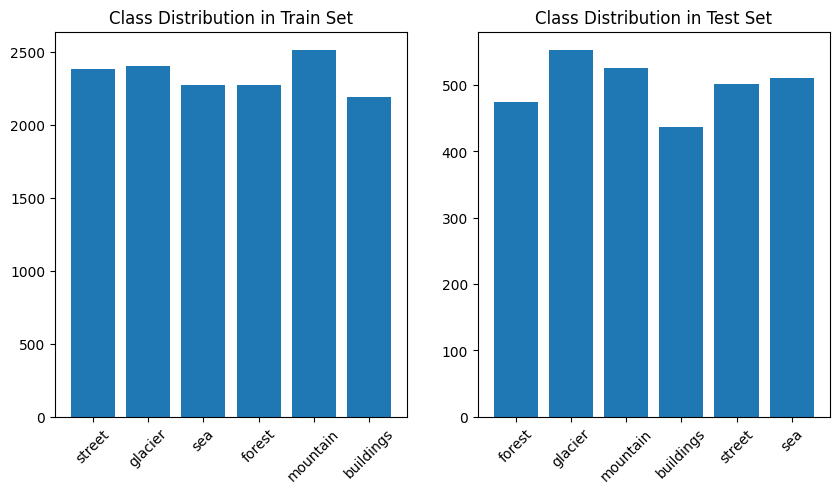

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(train_classes_counts.keys(), train_classes_counts.values())
plt.title('Class Distribution in Train Set')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(test_classes_counts.keys(), test_classes_counts.values())
plt.title('Class Distribution in Test Set')
plt.xticks(rotation=45)

plt.show()

In [ ]:
print(f"Data type: {X_train.dtype}")
print(f"Image shape: {X_train[0].shape}")

Data type: uint8
Image shape: (150, 150, 3)


## Extract Features Using HOG

In [ ]:
def extract_hog_features(images):
    features = []
    for image in images:
        # Convert image to grayscale as HOG needs a single channel image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_feature = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), visualize=False)
        features.append(hog_feature)
    return np.array(features)

In [ ]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

## Preprocess Features

In [ ]:
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

In [ ]:
from sklearn.metrics import classification_report

## classical features + knn/svm/linear classificator

In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(kernel='linear'),
    "Linear Classifier": SGDClassifier(loss='hinge')
}

In [ ]:
for name, model in models.items():
    model.fit(X_train_hog, y_train)
    y_pred = model.predict(X_test_hog)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

KNN Accuracy: 0.391
              precision    recall  f1-score   support

   buildings       0.62      0.17      0.27       437
      forest       0.32      1.00      0.49       474
     glacier       0.36      0.22      0.27       553
    mountain       0.40      0.34      0.37       525
         sea       0.49      0.58      0.53       510
      street       0.76      0.06      0.12       501

    accuracy                           0.39      3000
   macro avg       0.49      0.39      0.34      3000
weighted avg       0.49      0.39      0.34      3000

SVM Accuracy: 0.5946666666666667
              precision    recall  f1-score   support

   buildings       0.58      0.65      0.61       437
      forest       0.78      0.85      0.81       474
     glacier       0.47      0.53      0.50       553
    mountain       0.47      0.45      0.46       525
         sea       0.59      0.47      0.52       510
      street       0.72      0.66      0.69       501

    accuracy            

## CNN+MLP with your own architecture

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Classification_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Classification_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Classification_data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
350/350 [==============================] - 724s 2s/step - loss: 1.1553 - accuracy: 0.5462 - val_loss: 0.8948 - val_accuracy: 0.6573
Epoch 2/10
350/350 [==============================] - 730s 2s/step - loss: 0.8828 - accuracy: 0.6666 - val_loss: 0.7138 - val_accuracy: 0.7399
Epoch 3/10
350/350 [==============================] - 676s 2s/step - loss: 0.7866 - accuracy: 0.7086 - val_loss: 0.6909 - val_accuracy: 0.7550
Epoch 4/10
350/350 [==============================] - 673s 2s/step - loss: 0.7029 - accuracy: 0.7466 - val_loss: 0.6509 - val_accuracy: 0.7712
Epoch 5/10
350/350 [==============================] - 672s 2s/step - loss: 0.6533 - accuracy: 0.7668 - val_loss: 0.5561 - val_accuracy: 0.8075
Epoch 6/10
350/350 [==============================] - 668s 2s/step - loss: 0.6163 - accuracy: 0.7750 - val_loss: 0.5435 - val_accuracy: 0.8071
Epoch 7/10
350/350 [==============================] - 659s 2s/step - loss: 0.5952 - accuracy: 0.7909 - val_loss: 0.5548 - val_accuracy: 0.8053

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

94/94 [==============================] - 47s 494ms/step


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc}")

              precision    recall  f1-score   support

   buildings       0.77      0.88      0.82       437
      forest       0.95      0.97      0.96       474
     glacier       0.80      0.79      0.80       553
    mountain       0.85      0.73      0.78       525
         sea       0.82      0.85      0.83       510
      street       0.88      0.85      0.86       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000

93/93 [==============================] - 44s 475ms/step - loss: 0.4393 - accuracy: 0.8417
Test accuracy: 0.8417338728904724


## Finetuned CNN

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np

In [31]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [32]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [34]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model.h5', save_best_only=True, save_weights_only=True)

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
350/350 [==============================] - 190s 540ms/step - loss: 0.7228 - accuracy: 0.7281 - val_loss: 0.4674 - val_accuracy: 0.8301
Epoch 2/20
350/350 [==============================] - 161s 460ms/step - loss: 0.5003 - accuracy: 0.8170 - val_loss: 0.4280 - val_accuracy: 0.8409
Epoch 3/20
350/350 [==============================] - 170s 487ms/step - loss: 0.4462 - accuracy: 0.8375 - val_loss: 0.4219 - val_accuracy: 0.8416
Epoch 4/20
350/350 [==============================] - 168s 481ms/step - loss: 0.4340 - accuracy: 0.8428 - val_loss: 0.3968 - val_accuracy: 0.8499
Epoch 5/20
350/350 [==============================] - 169s 483ms/step - loss: 0.3985 - accuracy: 0.8536 - val_loss: 0.3802 - val_accuracy: 0.8588
Epoch 6/20
350/350 [==============================] - 157s 449ms/step - loss: 0.3863 - accuracy: 0.8612 - val_loss: 0.3610 - val_accuracy: 0.8639
Epoch 7/20
350/350 [==============================] - 166s 473ms/step - loss: 0.3732 - accuracy: 0.8607 - val_loss: 0.3875 -

In [38]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report Before Fine-Tuning:")
print(report)

94/94 [==============================] - 15s 152ms/step
Classification Report Before Fine-Tuning:
              precision    recall  f1-score   support

   buildings       0.94      0.87      0.90       437
      forest       0.97      0.98      0.98       474
     glacier       0.83      0.83      0.83       553
    mountain       0.81      0.83      0.82       525
         sea       0.91      0.87      0.89       510
      street       0.89      0.94      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



Below I tried to unfreeze last 4 layers of base model and train but I've got accuracy and loss are nearly constant and very low.

In [39]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
optimizer_ft = optimizers.Adam(lr=1e-5)
model.compile(optimizer=optimizer_ft, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_ft = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_finetuned.h5', save_best_only=True, save_weights_only=True)

In [42]:
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping_ft, checkpoint_ft]
)

Epoch 1/10
350/350 [==============================] - 157s 444ms/step - loss: 1.9965 - accuracy: 0.1796 - val_loss: 1.7909 - val_accuracy: 0.1792
Epoch 2/10
350/350 [==============================] - 157s 448ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7907 - val_accuracy: 0.1796
Epoch 3/10
350/350 [==============================] - 167s 476ms/step - loss: 1.7909 - accuracy: 0.1791 - val_loss: 1.7908 - val_accuracy: 0.1792
Epoch 4/10
350/350 [==============================] - 158s 451ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7909 - val_accuracy: 0.1778
Epoch 5/10
350/350 [==============================] - 169s 482ms/step - loss: 1.7910 - accuracy: 0.1786 - val_loss: 1.7907 - val_accuracy: 0.1800
Epoch 6/10
350/350 [==============================] - 157s 447ms/step - loss: 1.7910 - accuracy: 0.1788 - val_loss: 1.7907 - val_accuracy: 0.1792
Epoch 7/10
350/350 [==============================] - 168s 481ms/step - loss: 1.7909 - accuracy: 0.1791 - val_loss: 1.7908 -

In [43]:
test_generator.reset()
predictions_finetuned = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes_finetuned = np.argmax(predictions_finetuned, axis=1)
report_finetuned = classification_report(true_classes, predicted_classes_finetuned, target_names=class_labels)
print("Classification Report After Fine-Tuning:")
print(report_finetuned)

94/94 [==============================] - 13s 138ms/step
Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.17      1.00      0.30       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
